In [2]:
import warnings
warnings.filterwarnings('ignore')
from notebooks.util.distribution_utils import *

from liquidity.response_functions.features import compute_returns
from hurst_exponent.util.utils import augmented_dickey_fuller

In [3]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [4]:
# Number of events to use
EVENTS_RANGE = 500000

## Load market orders raw sample data

In [5]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

In [6]:
tsla_raw_df.columns

Index(['Unnamed: 0', 'event_timestamp', 'sign', 'side', 'lob_action',
       'order_executed', 'execution_price', 'size', 'ask', 'bid', 'midprice',
       'ask_volume', 'bid_volume', 'price_changing', 'midprice_change', 'R1',
       'date', 'daily_R1', 'daily_vol', 'daily_num', 'norm_size'],
      dtype='object')

## 1. Returns

In [5]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# returns = {stock: data.head(1000000) for stock, data in returns.items()}

### 1.1. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [6]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.78
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.00
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.79
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 1.2. Plot returns density functions

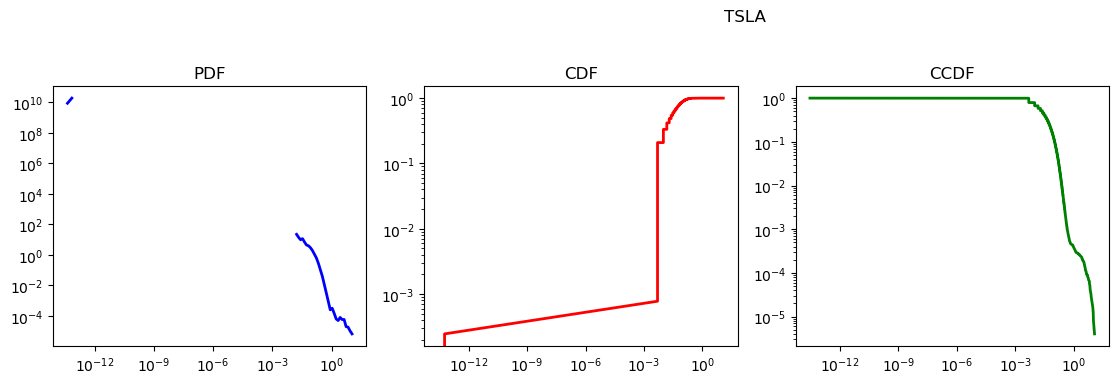

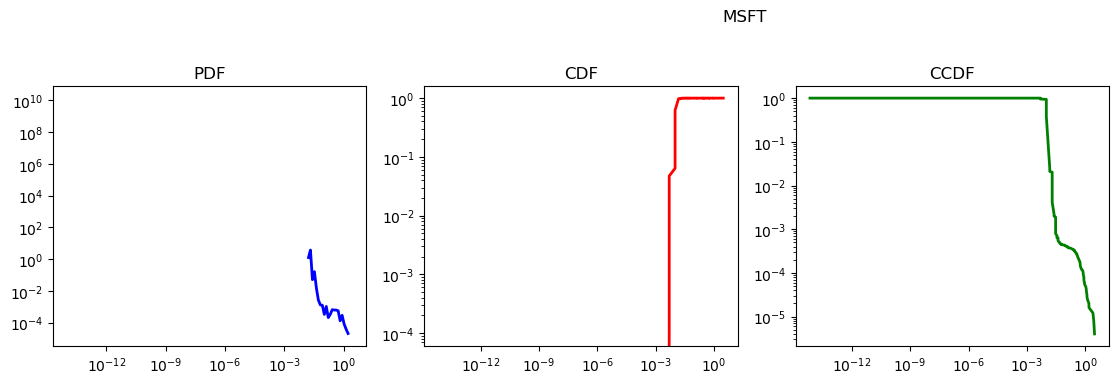

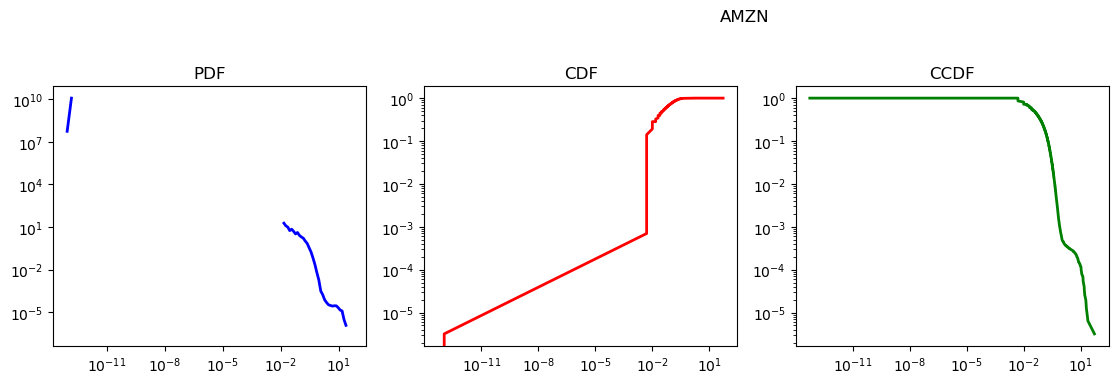

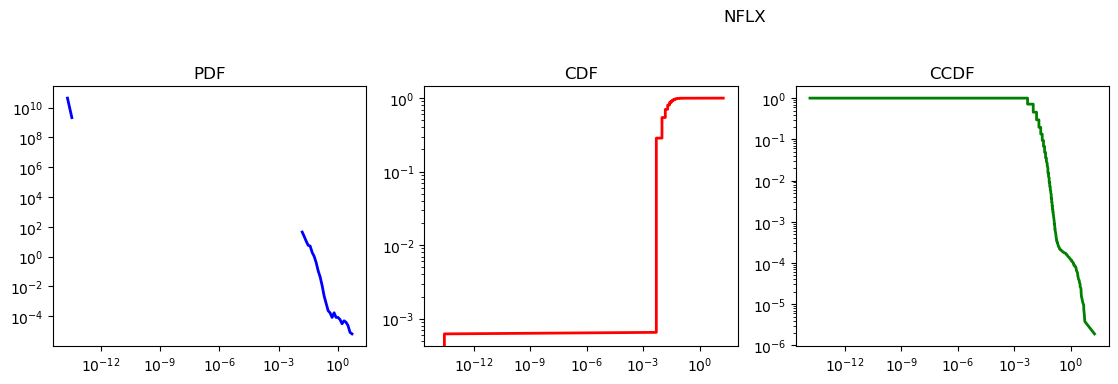

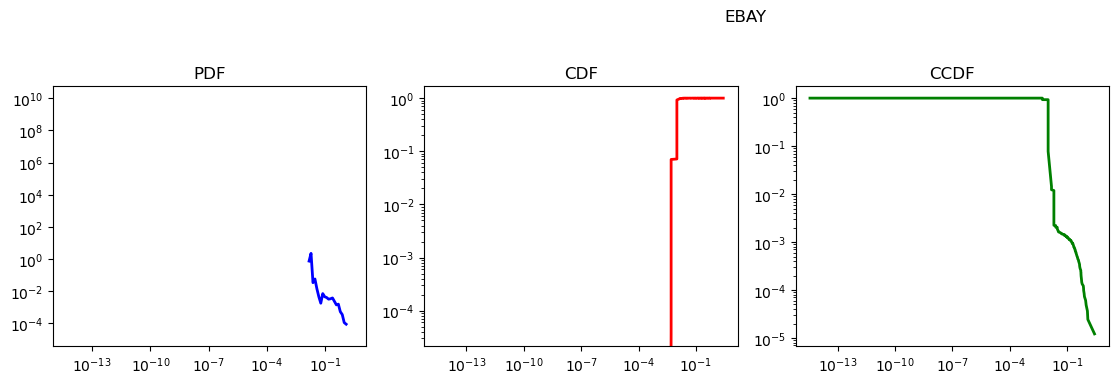

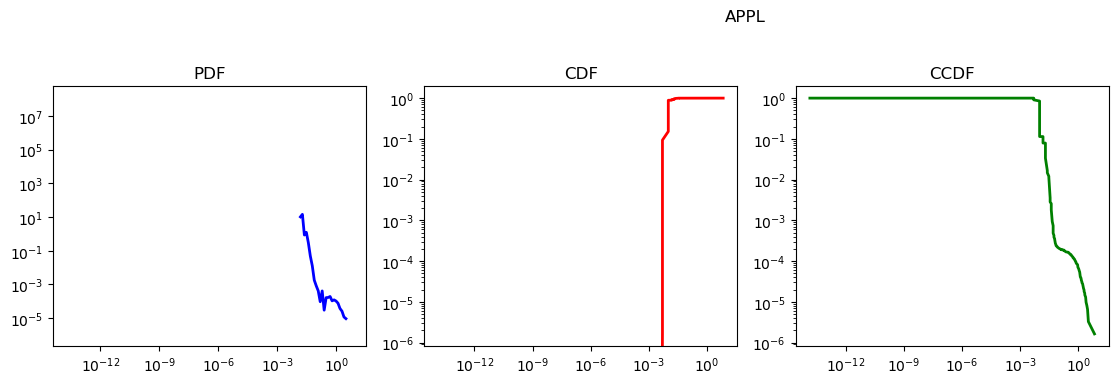

In [7]:
# Plot for each stock
for stock_name, data in returns.items():
    plot_distributions(stock_name, data)

### 1.3. Fit returns power law distribution

In [8]:
# 1. Fit Powerlaw and retrieve fitted object/ results
returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_returns_distributions.pkl')

if not os.path.exists(returns_distributions_data):
    returns_fit_objects = fit_powerlaw(data_dict=returns, filename=returns_distributions_data)
else:
    returns_fit_objects = load_fit_objects(returns_distributions_data)

returns_fit_objects

{'TSLA': <powerlaw.Fit at 0x29b55a0d0>,
 'MSFT': <powerlaw.Fit at 0x2961f8650>,
 'AMZN': <powerlaw.Fit at 0x296190210>,
 'NFLX': <powerlaw.Fit at 0x29573cc90>,
 'EBAY': <powerlaw.Fit at 0x306ea0790>,
 'APPL': <powerlaw.Fit at 0x359d24790>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

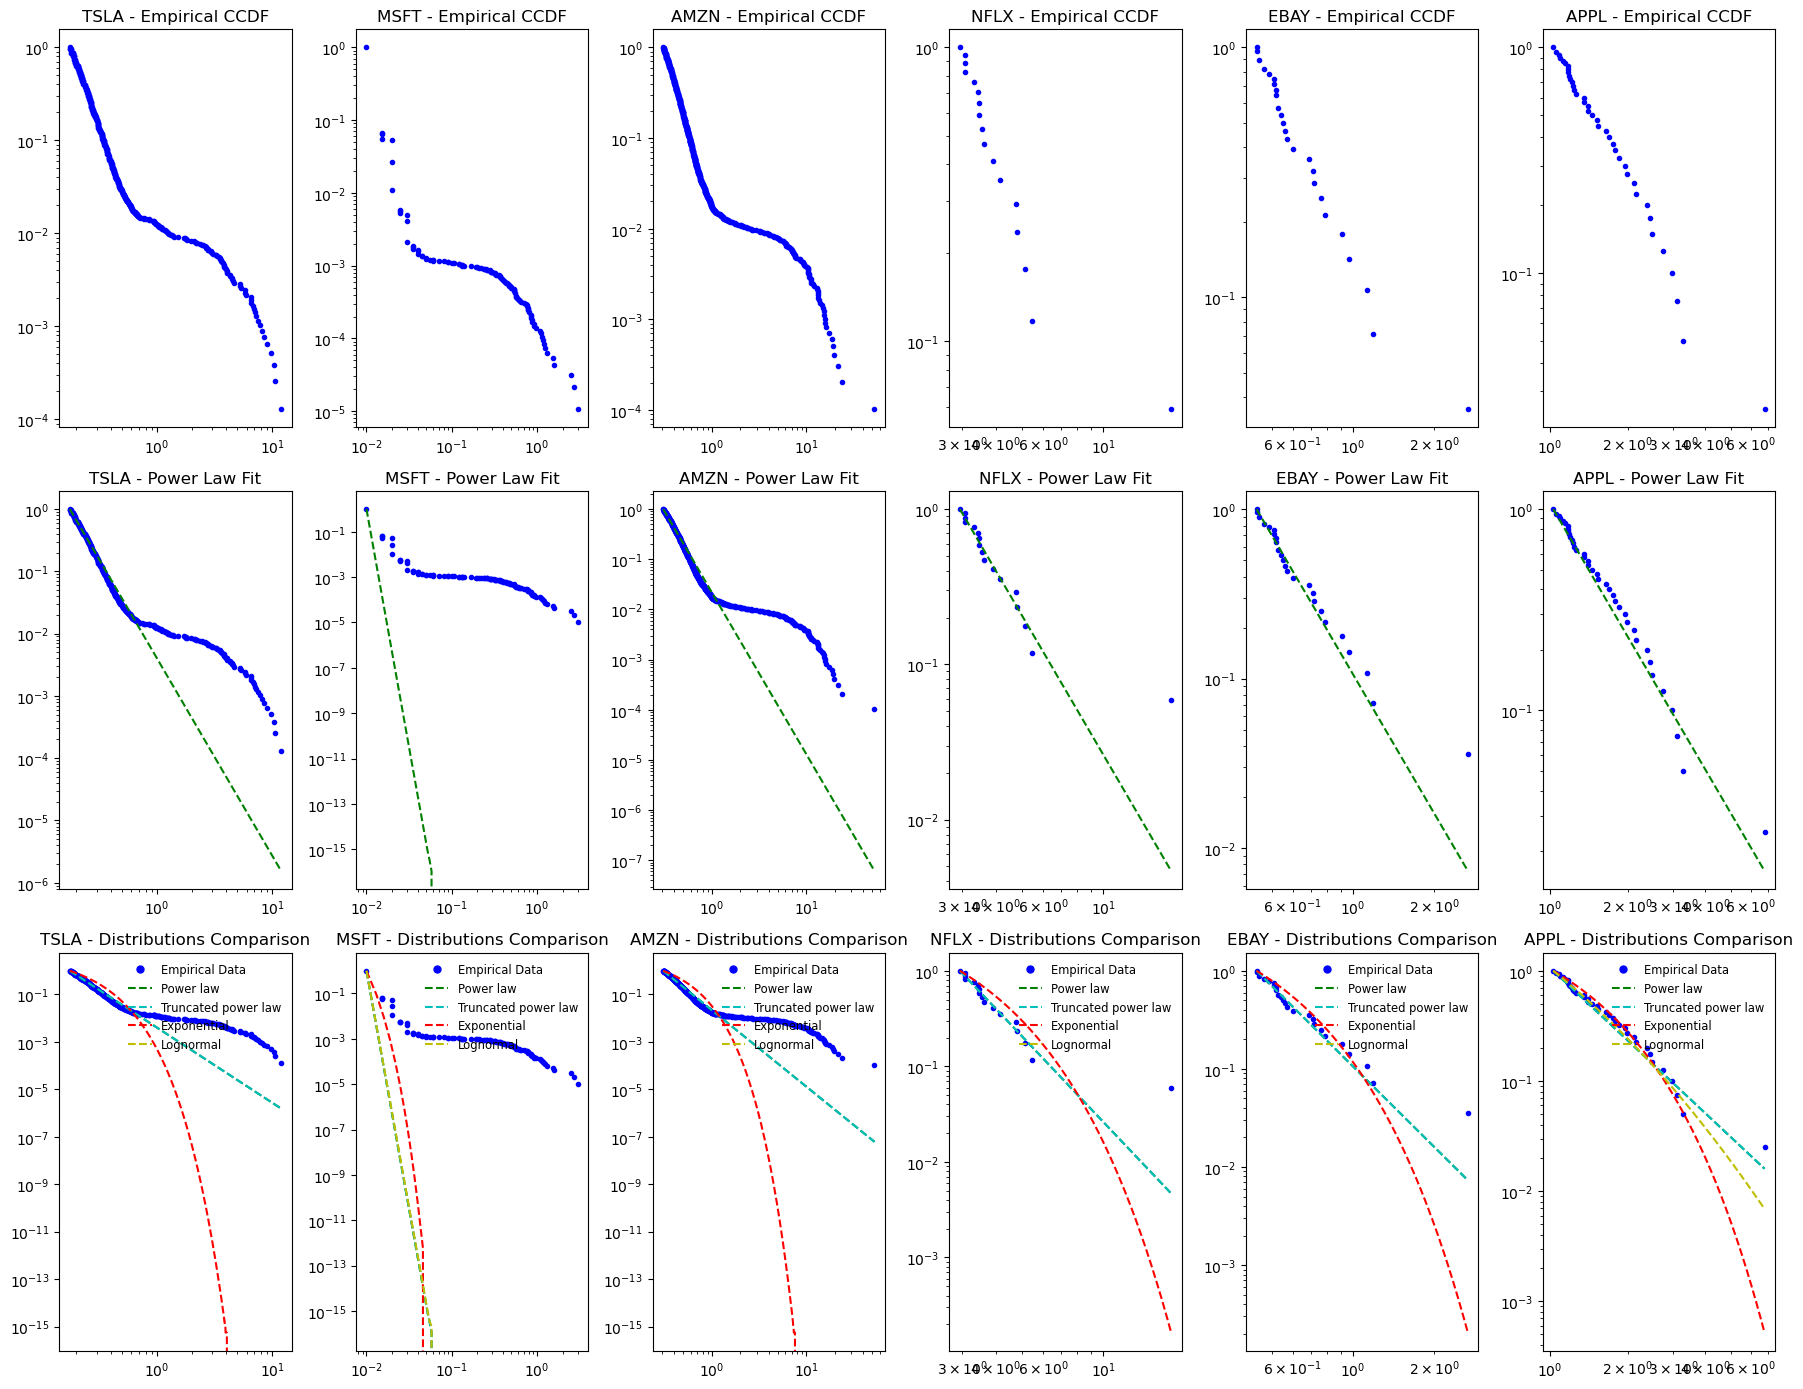

In [9]:
# Plot fitted objects
plot_fit_objects(returns_fit_objects)

#### 1.3.1. Retrieve returns power law fitting results

In [10]:
# Get fitting parameters for specific distribution across all stocks
returns_power_results = get_fitting_params(returns_fit_objects, 'power_law')
print(returns_power_results)

  Stock Distribution      alpha   xmin  KS Distance
0  TSLA    power_law   4.166712  0.175     0.047110
1  MSFT    power_law  22.033504  0.010     0.065830
2  AMZN    power_law   4.225215  0.305     0.031460
3  NFLX    power_law   3.974212  2.940     0.079087
4  EBAY    power_law   3.732640  0.440     0.081979
5  APPL    power_law   3.196989  1.030     0.069865


In [11]:
# Average Alpha exponents across stocks
min_alpha = returns_power_results['alpha'].min()
max_alpha = returns_power_results['alpha'].max()
avg_alpha = returns_power_results['alpha'].mean()
std_dev_alpha = returns_power_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.196989095751305
Max Alpha: 22.033504473801685
Average Alpha: 6.888212088759396
std_dev_alpha: 7.429026275855144


#### 1.3.2. Compare Alternative Distributions

In [12]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
returns_powerlaw_exponential = distribution_compare(returns_fit_objects, 'exponential')
display(returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,9.236883,0.175,4.166712,0.047110,0.203563,9.689827,3.330929e-22
1,MSFT,exponential,788.735510,0.010,22.033504,0.065830,0.052912,16.374386,2.914348e-60
2,AMZN,exponential,4.938523,0.305,4.225215,0.031460,0.231028,10.411757,2.191386e-25
3,NFLX,exponential,0.584483,2.940,3.974212,0.079087,0.199483,1.564487,1.177033e-01
4,EBAY,exponential,3.825132,0.440,3.732640,0.081979,0.179619,1.228318,2.193277e-01
5,APPL,exponential,1.317513,1.030,3.196989,0.069865,0.113578,0.387983,6.980285e-01


## 2. Percentage returns

In [13]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'APPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### 2.1. Stationarity Test

In [14]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.55
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -351.01
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.59
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.80
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 2.2. Percentage return density functions

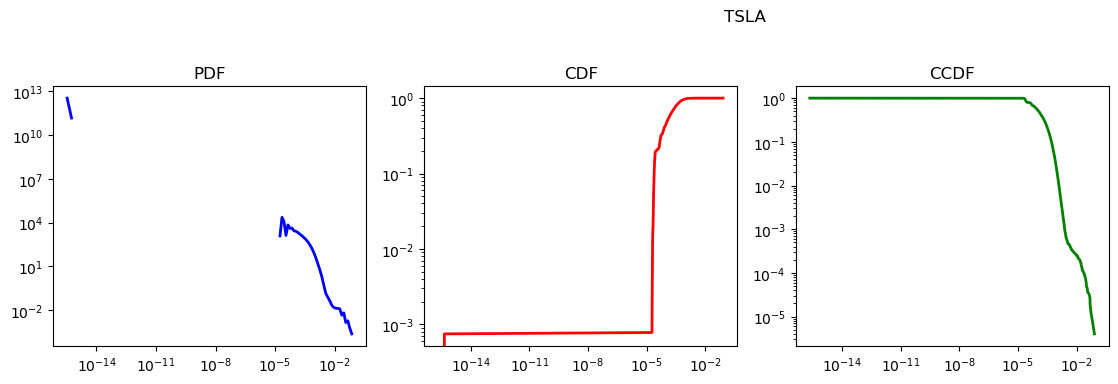

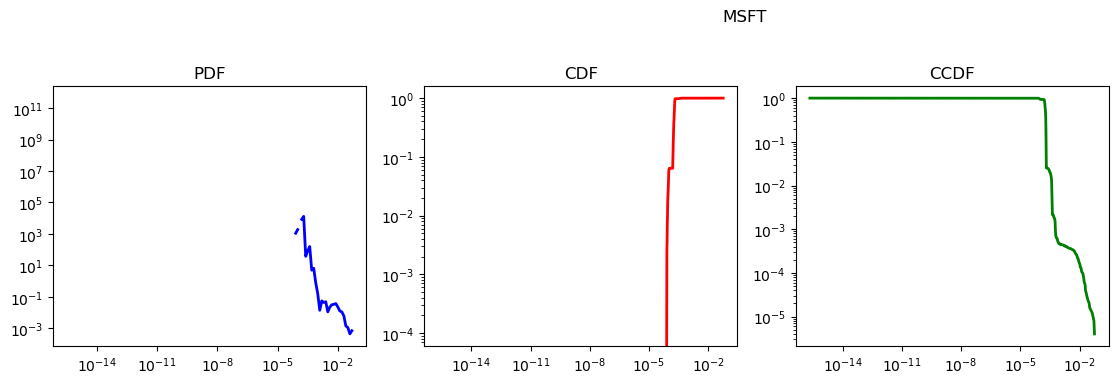

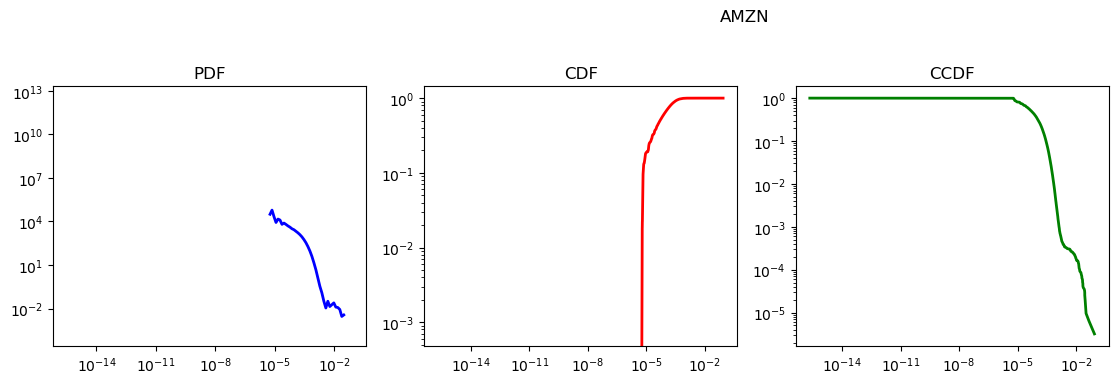

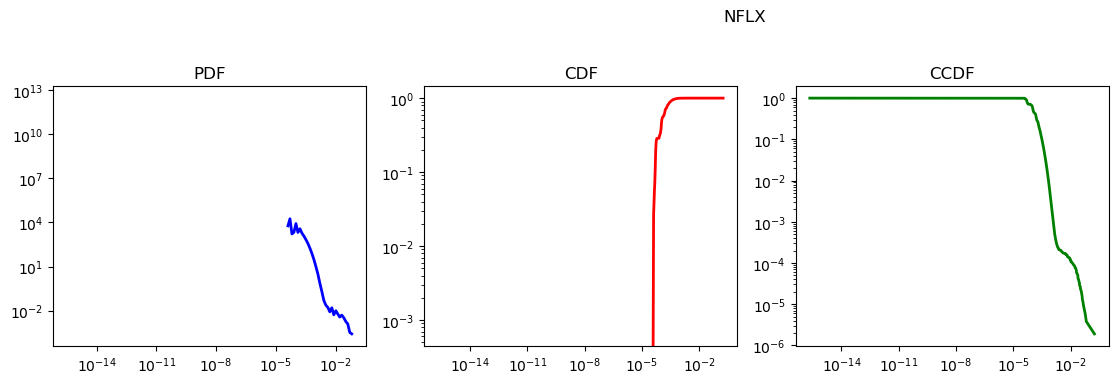

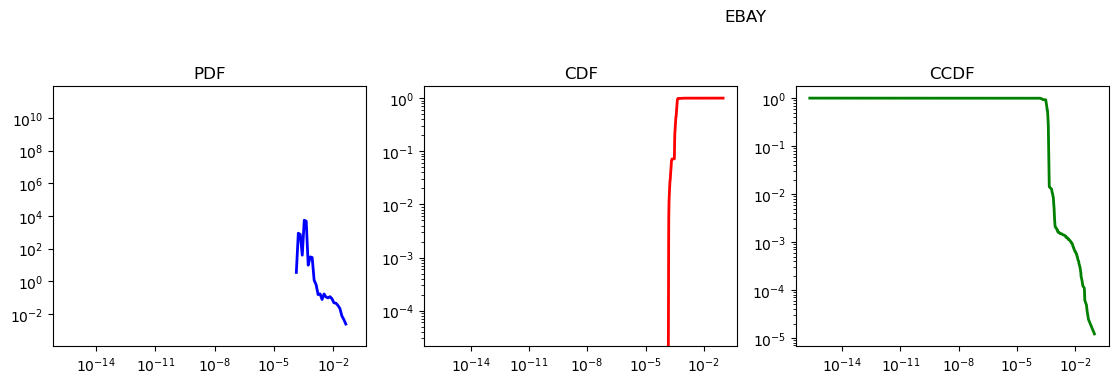

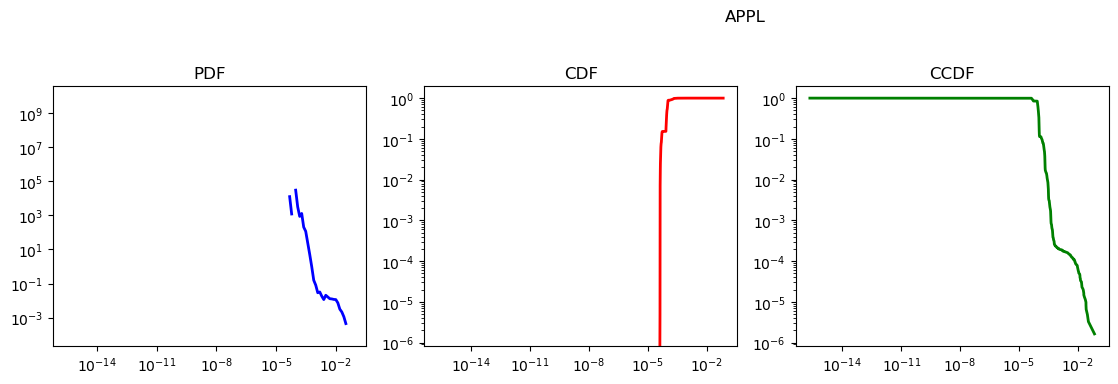

In [15]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in percentage_returns.items():
    plot_distributions(stock_name, data)

### 2.3. Fit power law distribution to percentage returns

In [16]:
# 1. Fit Powerlaw and retrieve fitted object/ results
percentage_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_percentage_returns_distributions.pkl')

if not os.path.exists(percentage_returns_distributions_data):
    percentage_returns_fit_objects = fit_powerlaw(data_dict=percentage_returns, filename=percentage_returns_distributions_data)
else:
    percentage_returns_fit_objects = load_fit_objects(percentage_returns_distributions_data)

percentage_returns_fit_objects

{'TSLA': <powerlaw.Fit at 0x282db3310>,
 'MSFT': <powerlaw.Fit at 0x282d66910>,
 'AMZN': <powerlaw.Fit at 0x2bcb20c50>,
 'NFLX': <powerlaw.Fit at 0x2944f65d0>,
 'EBAY': <powerlaw.Fit at 0x282ee6850>,
 'APPL': <powerlaw.Fit at 0x2c1c91710>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

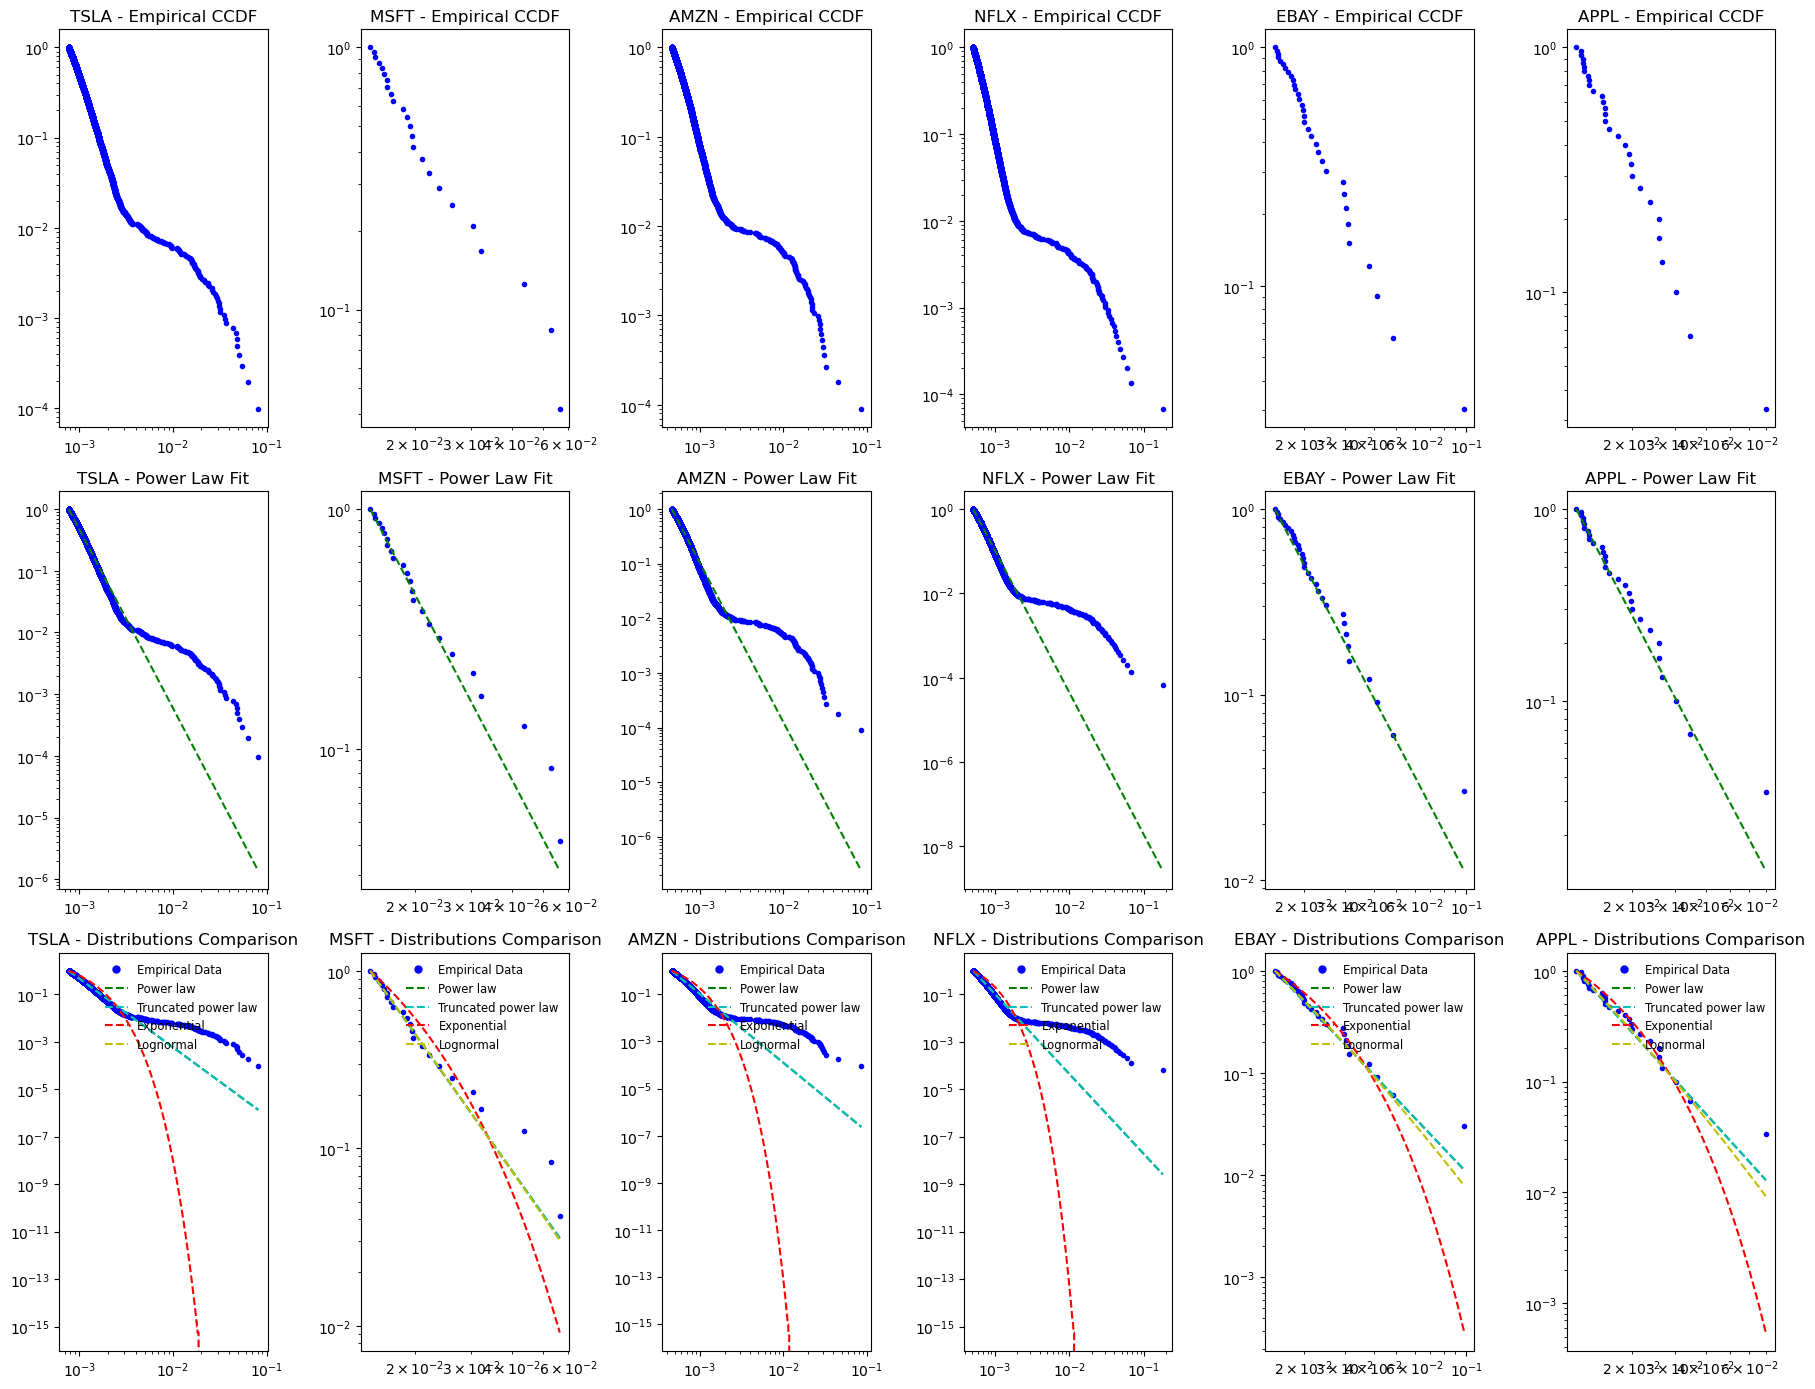

In [17]:
# Plot fitted objects
plot_fit_objects(percentage_returns_fit_objects)

#### 2.3.1. Retrieve Power law fitting results

In [18]:
# Get fitting parameters for specific distribution across all stocks
percentage_returns_power_results = get_fitting_params(percentage_returns_fit_objects, 'power_law')
print(percentage_returns_power_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.897987  0.000771     0.019991
1  MSFT    power_law  3.559261  0.014551     0.064610
2  AMZN    power_law  3.915487  0.000461     0.028275
3  NFLX    power_law  4.378032  0.000514     0.021699
4  EBAY    power_law  3.392282  0.015018     0.075980
5  APPL    power_law  3.459600  0.011946     0.078574


In [19]:
# Average Alpha exponents across stocks
min_alpha = percentage_returns_power_results['alpha'].min()
max_alpha = percentage_returns_power_results['alpha'].max()
avg_alpha = percentage_returns_power_results['alpha'].mean()
std_dev_alpha = percentage_returns_power_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.39228225304039
Max Alpha: 4.378032012554931
Average Alpha: 3.7671083850966824
std_dev_alpha: 0.3716530291752204


#### 2.3.2. Compare Alternative Distributions

In [20]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
percentage_returns_powerlaw_exponential = distribution_compare(percentage_returns_fit_objects, 'exponential')
display(percentage_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,1993.895885,0.000771,3.897987,0.019991,0.162308,8.536606,1.382221e-17
1,MSFT,exponential,112.164350,0.014551,3.559261,0.064610,0.145147,1.126268,2.600520e-01
2,AMZN,exponential,3151.428930,0.000461,3.915487,0.028275,0.181532,9.031559,1.692435e-19
3,NFLX,exponential,3232.188057,0.000514,4.378032,0.021699,0.197939,7.809402,5.745997e-15
4,EBAY,exponential,98.067612,0.015018,3.392282,0.075980,0.123586,0.798590,4.245284e-01
5,APPL,exponential,129.534003,0.011946,3.459600,0.078574,0.119130,0.704757,4.809613e-01


## 3. Log Returns

In [21]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df, )['log_returns']
msft_log_returns = compute_returns(msft_raw_df, )['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df,)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df, )['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df,)['log_returns']
appl_log_returns = compute_returns(appl_raw_df,)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'APPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### 3.1. Stationarity Test

In [22]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -313.58
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -350.98
p-value: 0.00,
N: 499995, 
critical values: {'1%': -3.430363078797933, '5%': -2.8615457806747435, '10%': -2.5667730768420047}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -313.60
p-value: 0.00,
N: 499994, 
critical values: {'1%': -3.430363078824091, '5%': -2.861545780686305, '10%': -2.5667730768481585}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -284.79
p-value: 0.00,
N: 499993, 
critical values: {'1%': -3.4303630788502493, '5%': -2.8615457806978664, '10%': -2.566773076854312}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


### 3.2. Log return density functions

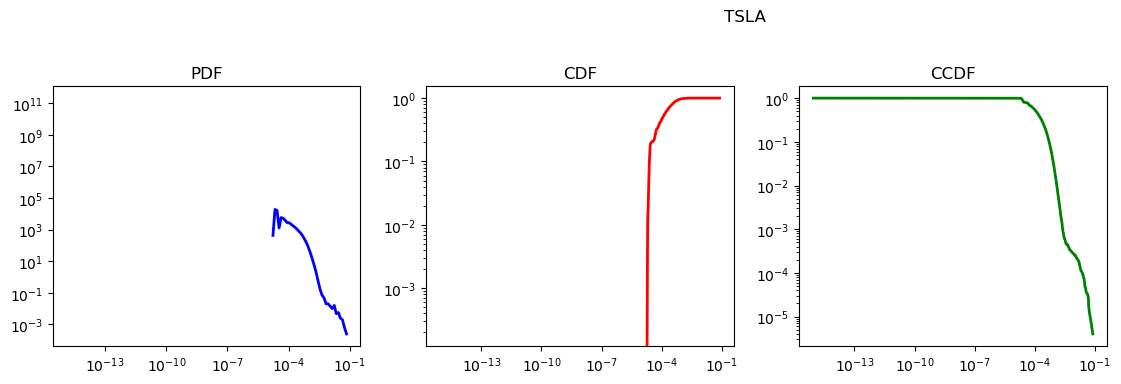

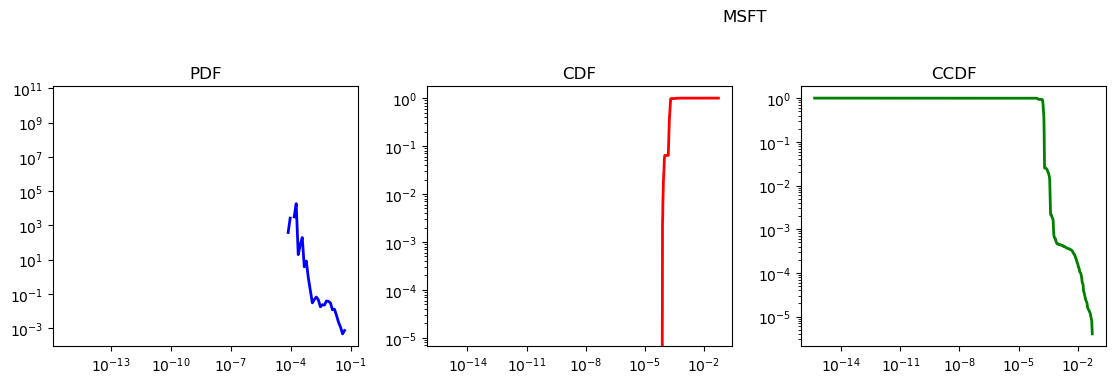

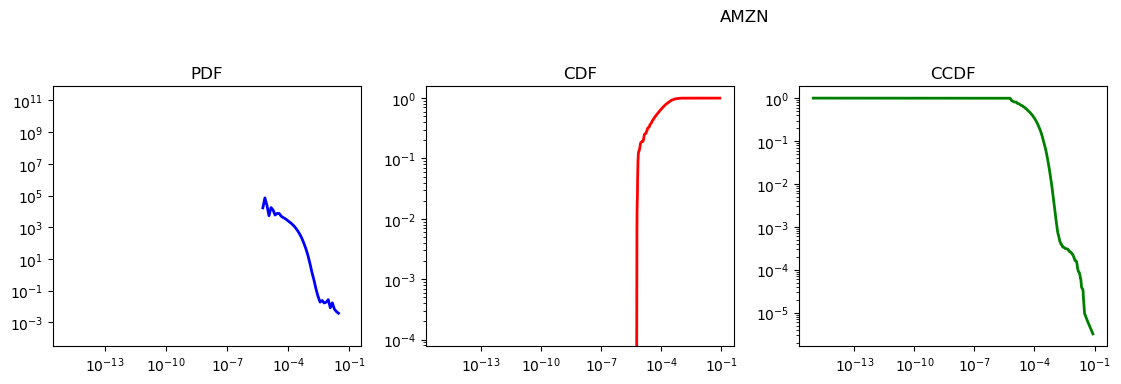

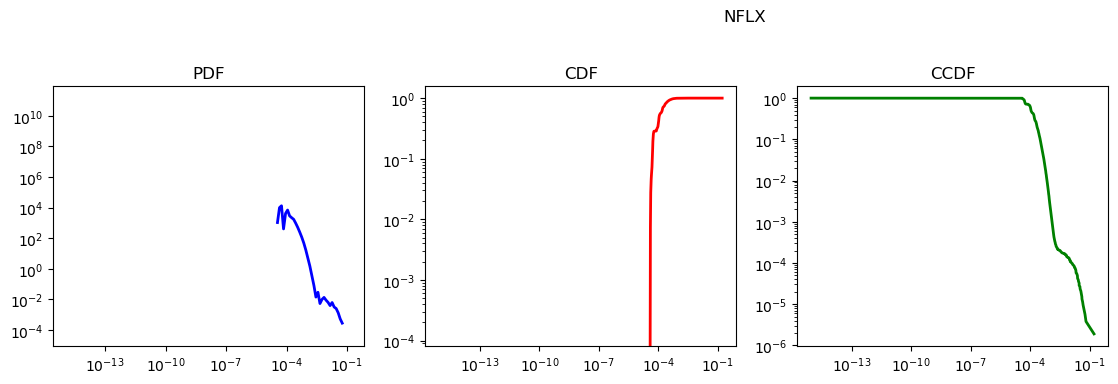

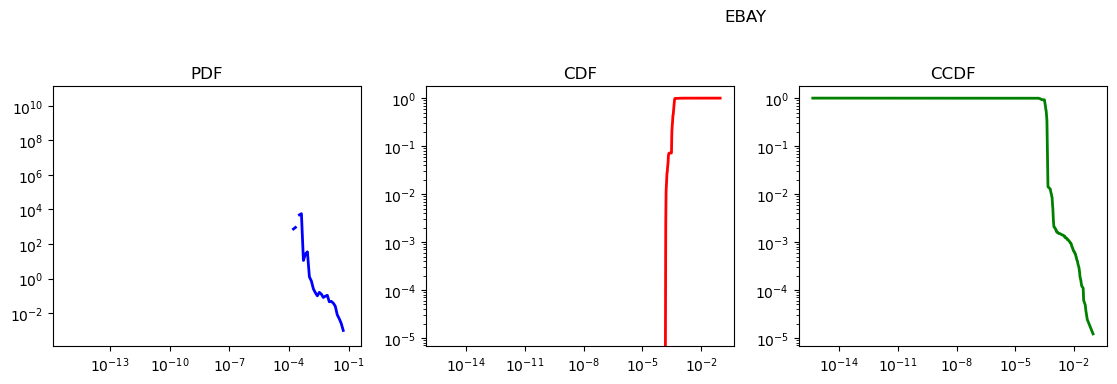

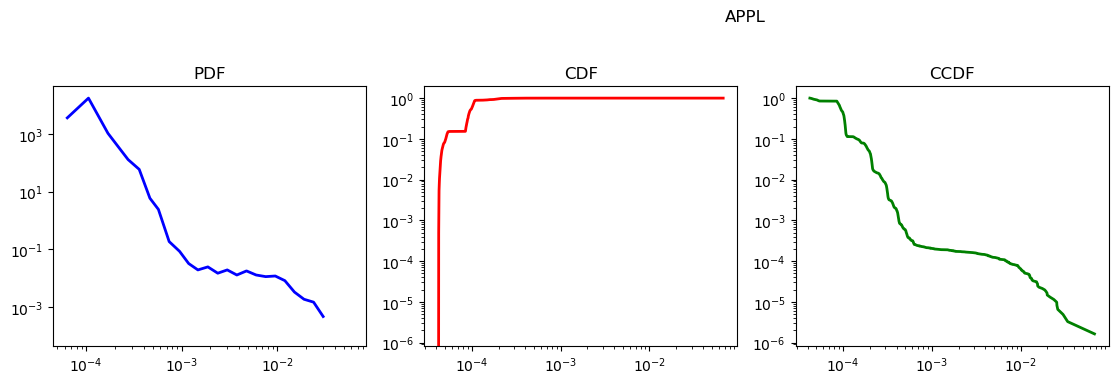

In [23]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in log_returns.items():
    plot_distributions(stock_name, data)

### 3.3. Fit power law distribution to log returns

In [24]:
# 1. Fit Powerlaw and retrieve fitted object/ results
log_returns_distributions_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_log_returns_distributions.pkl')

if not os.path.exists(log_returns_distributions_data):
    log_returns_fit_objects = fit_powerlaw(data_dict=log_returns, filename=log_returns_distributions_data)
else:
    log_returns_fit_objects = load_fit_objects(log_returns_distributions_data)

log_returns_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x2c1db91d0>,
 'MSFT': <powerlaw.Fit at 0x2c088a050>,
 'AMZN': <powerlaw.Fit at 0x2c04fd0d0>,
 'NFLX': <powerlaw.Fit at 0x2bcc2e410>,
 'EBAY': <powerlaw.Fit at 0x2bcc2f810>,
 'APPL': <powerlaw.Fit at 0x2bcc2c950>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

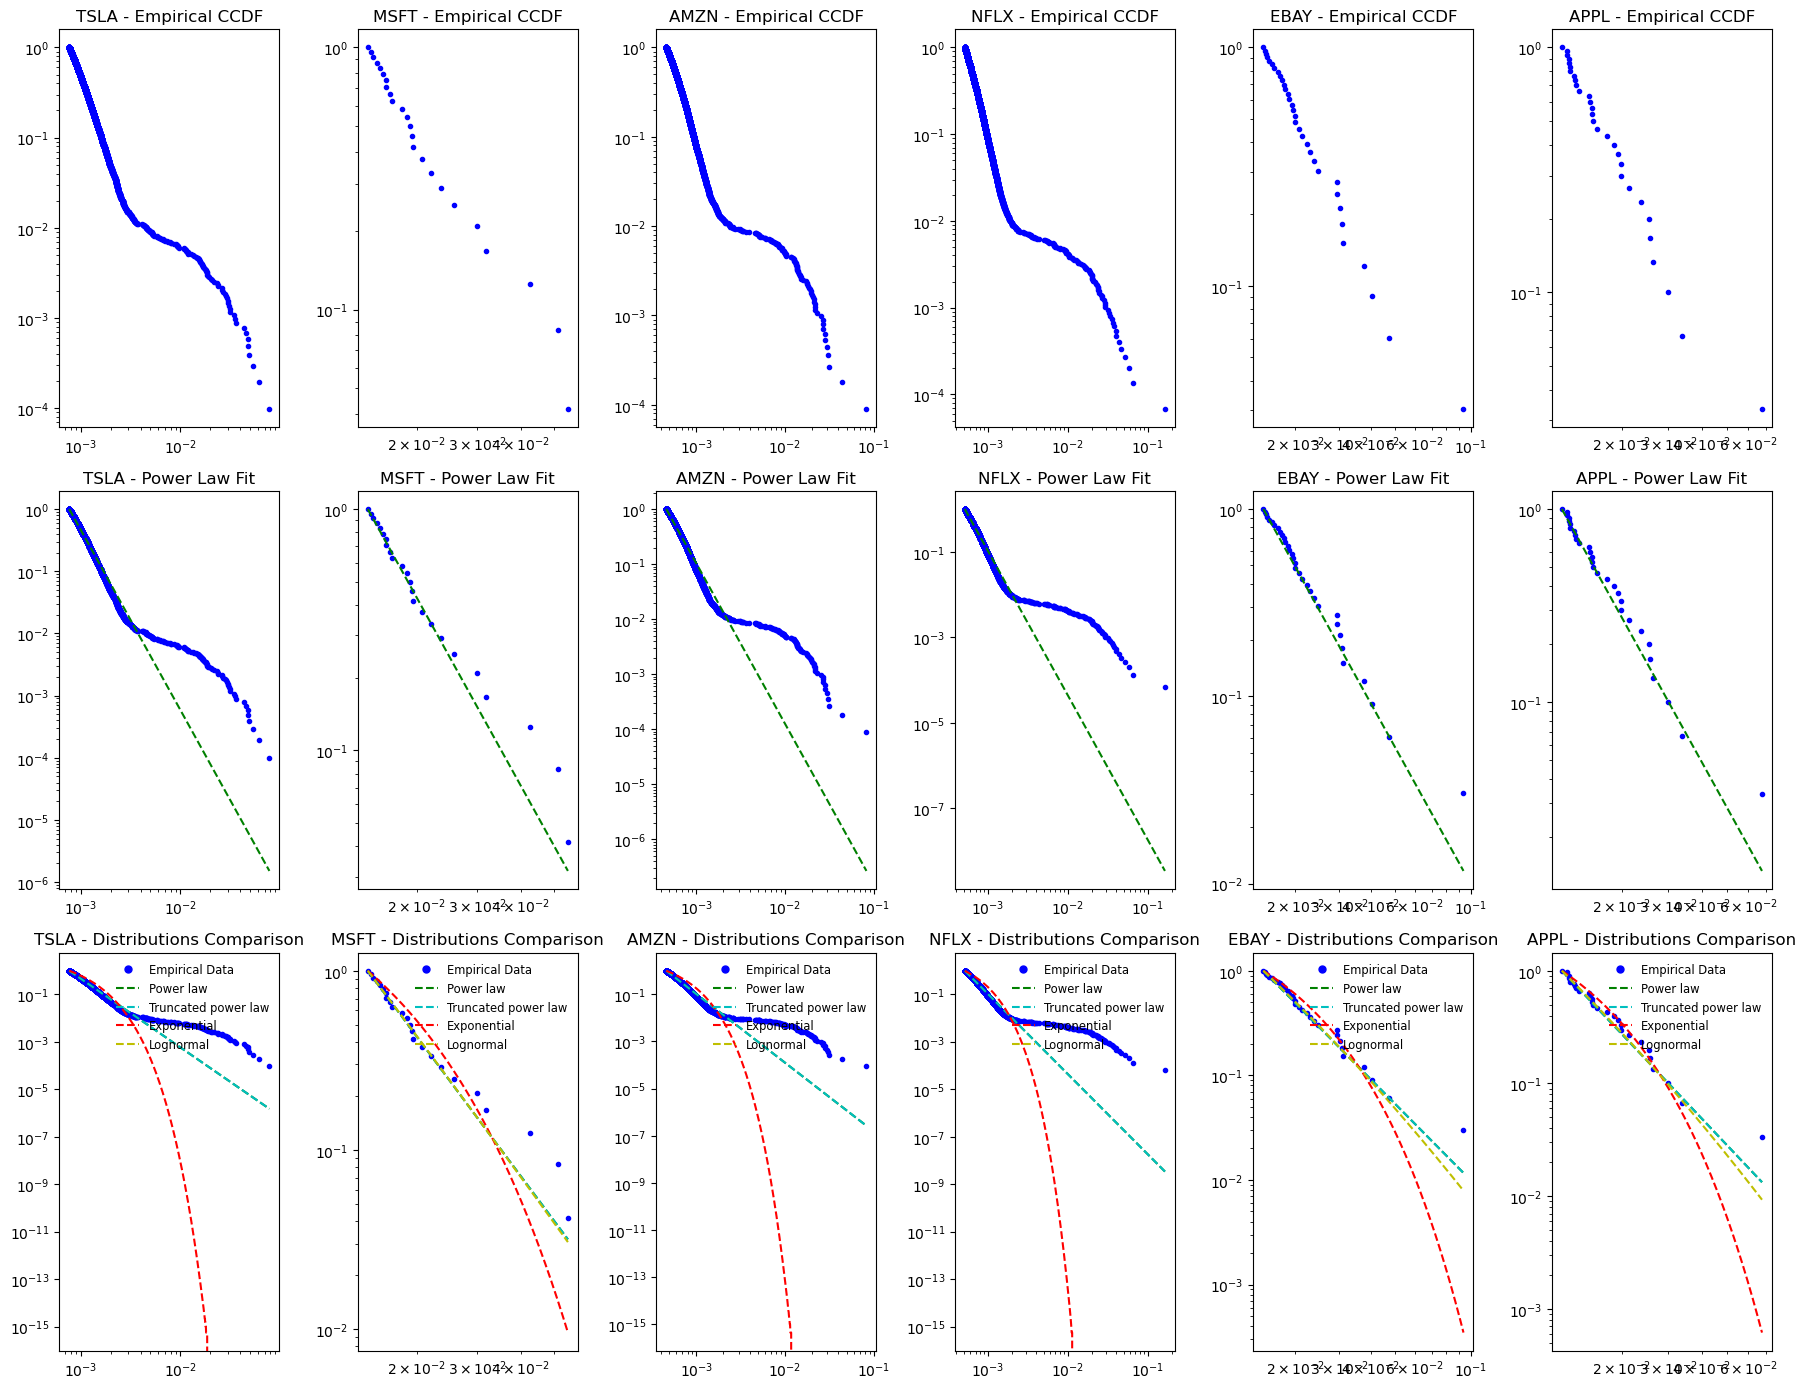

In [25]:
# Plot fitted objects
plot_fit_objects(log_returns_fit_objects)

#### 3.3.1. Retrieve Power law fitting results

In [26]:
# Get fitting parameters for specific distribution across all stocks
log_returns_power_results = get_fitting_params(log_returns_fit_objects, 'power_law')
print(log_returns_power_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.900085  0.000770     0.019955
1  MSFT    power_law  3.588156  0.014446     0.064308
2  AMZN    power_law  3.916831  0.000461     0.028248
3  NFLX    power_law  4.379786  0.000514     0.021724
4  EBAY    power_law  3.421069  0.014907     0.076411
5  APPL    power_law  3.482720  0.011876     0.079444


In [27]:
# Average Alpha exponents across stocks
min_alpha = log_returns_power_results['alpha'].min()
max_alpha = log_returns_power_results['alpha'].max()
avg_alpha = log_returns_power_results['alpha'].mean()
std_dev_alpha = log_returns_power_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.4210690952420033
Max Alpha: 4.379785661594162
Average Alpha: 3.7814412139880367
std_dev_alpha: 0.3596900203696775


#### 3.3.2. Compare Alternative Distributions

In [28]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
log_returns_powerlaw_exponential = distribution_compare(log_returns_fit_objects, 'exponential')
display(log_returns_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,2005.198916,0.000770,3.900085,0.019955,0.160745,8.578761,9.590050e-18
1,MSFT,exponential,115.113083,0.014446,3.588156,0.064308,0.142234,1.085166,2.778481e-01
2,AMZN,exponential,3166.126204,0.000461,3.916831,0.028248,0.180144,9.103021,8.785364e-20
3,NFLX,exponential,3259.715898,0.000514,4.379786,0.021724,0.195308,8.006348,1.181654e-15
4,EBAY,exponential,101.108519,0.014907,3.421069,0.076411,0.119601,0.757461,4.487737e-01
5,APPL,exponential,132.568653,0.011876,3.482720,0.079444,0.116317,0.674401,5.000562e-01


## 4. Return magnitudes (volatility)

In [29]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'APPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#return_magnitudes = {stock: data.head(1000000) for stock, data in return_magnitudes.items()}

### 4.1. Stationarity Test

In [30]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -49.89
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -54.43
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -52.60
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -50.20
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.




### 4.2. Volatility density functions

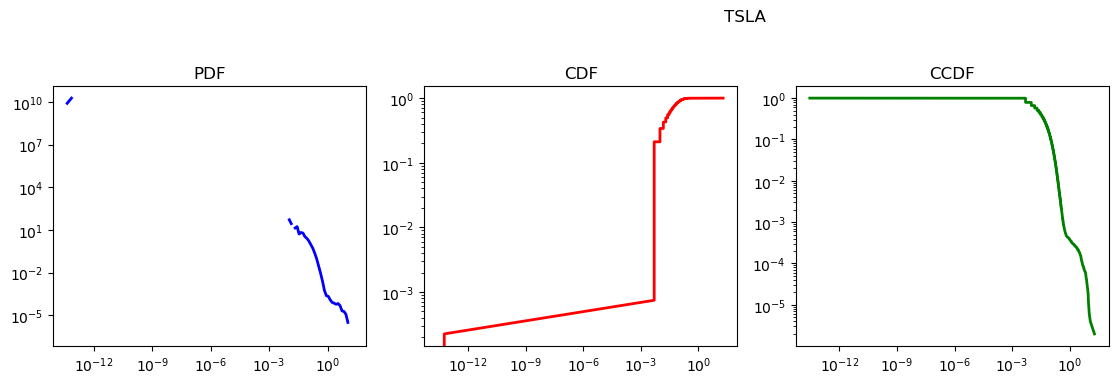

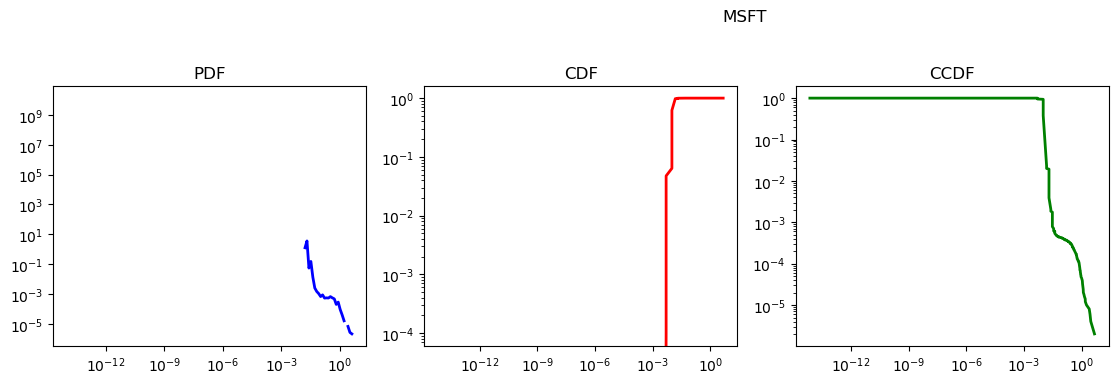

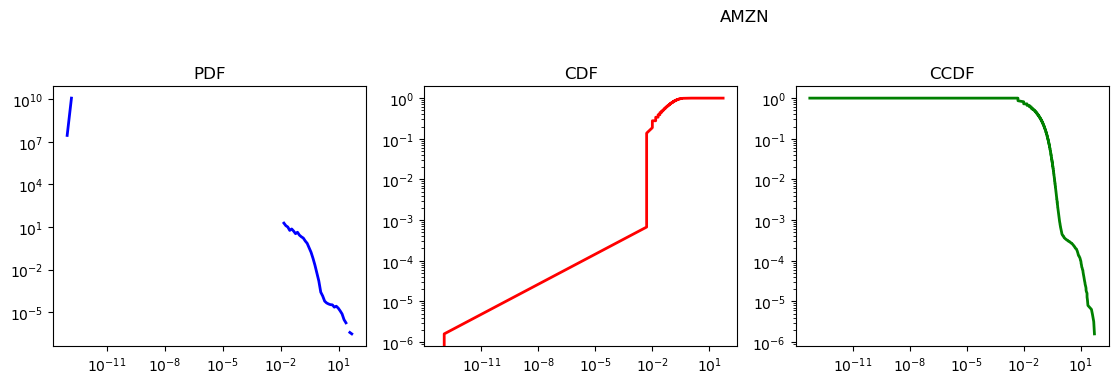

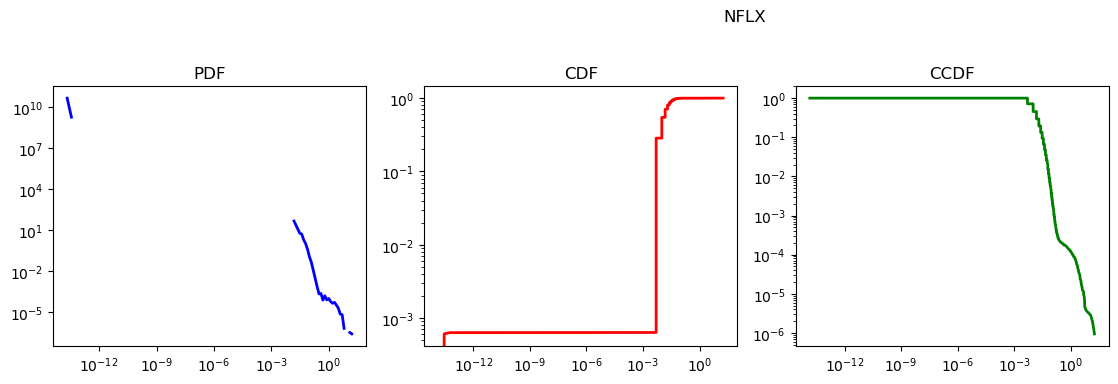

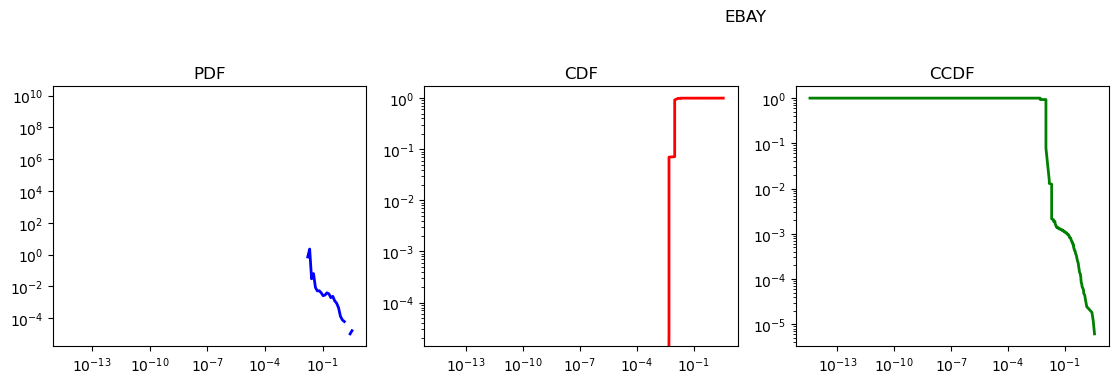

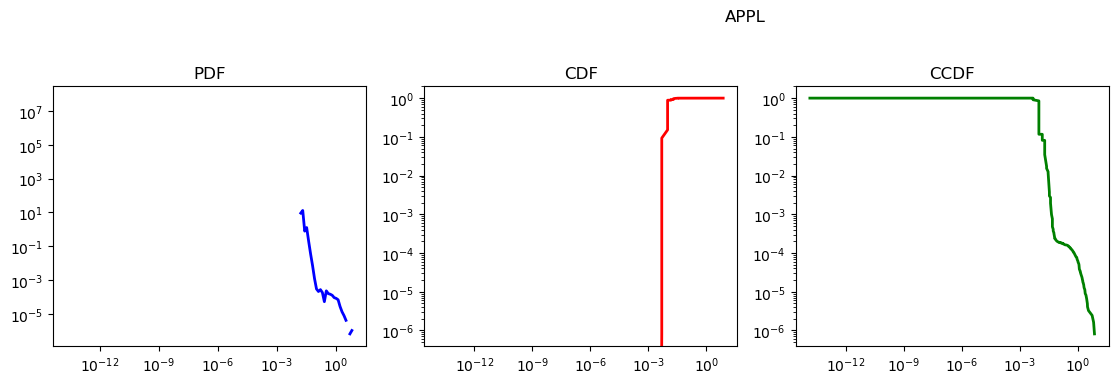

In [31]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in return_magnitudes.items():
    plot_distributions(stock_name, data)

### 4.3. Fit power law distribution to log returns

In [32]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volatility_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_volatility_distributions.pkl')

if not os.path.exists(volatility_data):
    volatility_fit_objects = fit_powerlaw(data_dict=return_magnitudes, filename=volatility_data)
else:
    volatility_fit_objects = load_fit_objects(volatility_data)

volatility_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x2bd9b9410>,
 'MSFT': <powerlaw.Fit at 0x29b36d990>,
 'AMZN': <powerlaw.Fit at 0x2bdaff910>,
 'NFLX': <powerlaw.Fit at 0x2bcc88f90>,
 'EBAY': <powerlaw.Fit at 0x29b44a410>,
 'APPL': <powerlaw.Fit at 0x29612f250>}

'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the

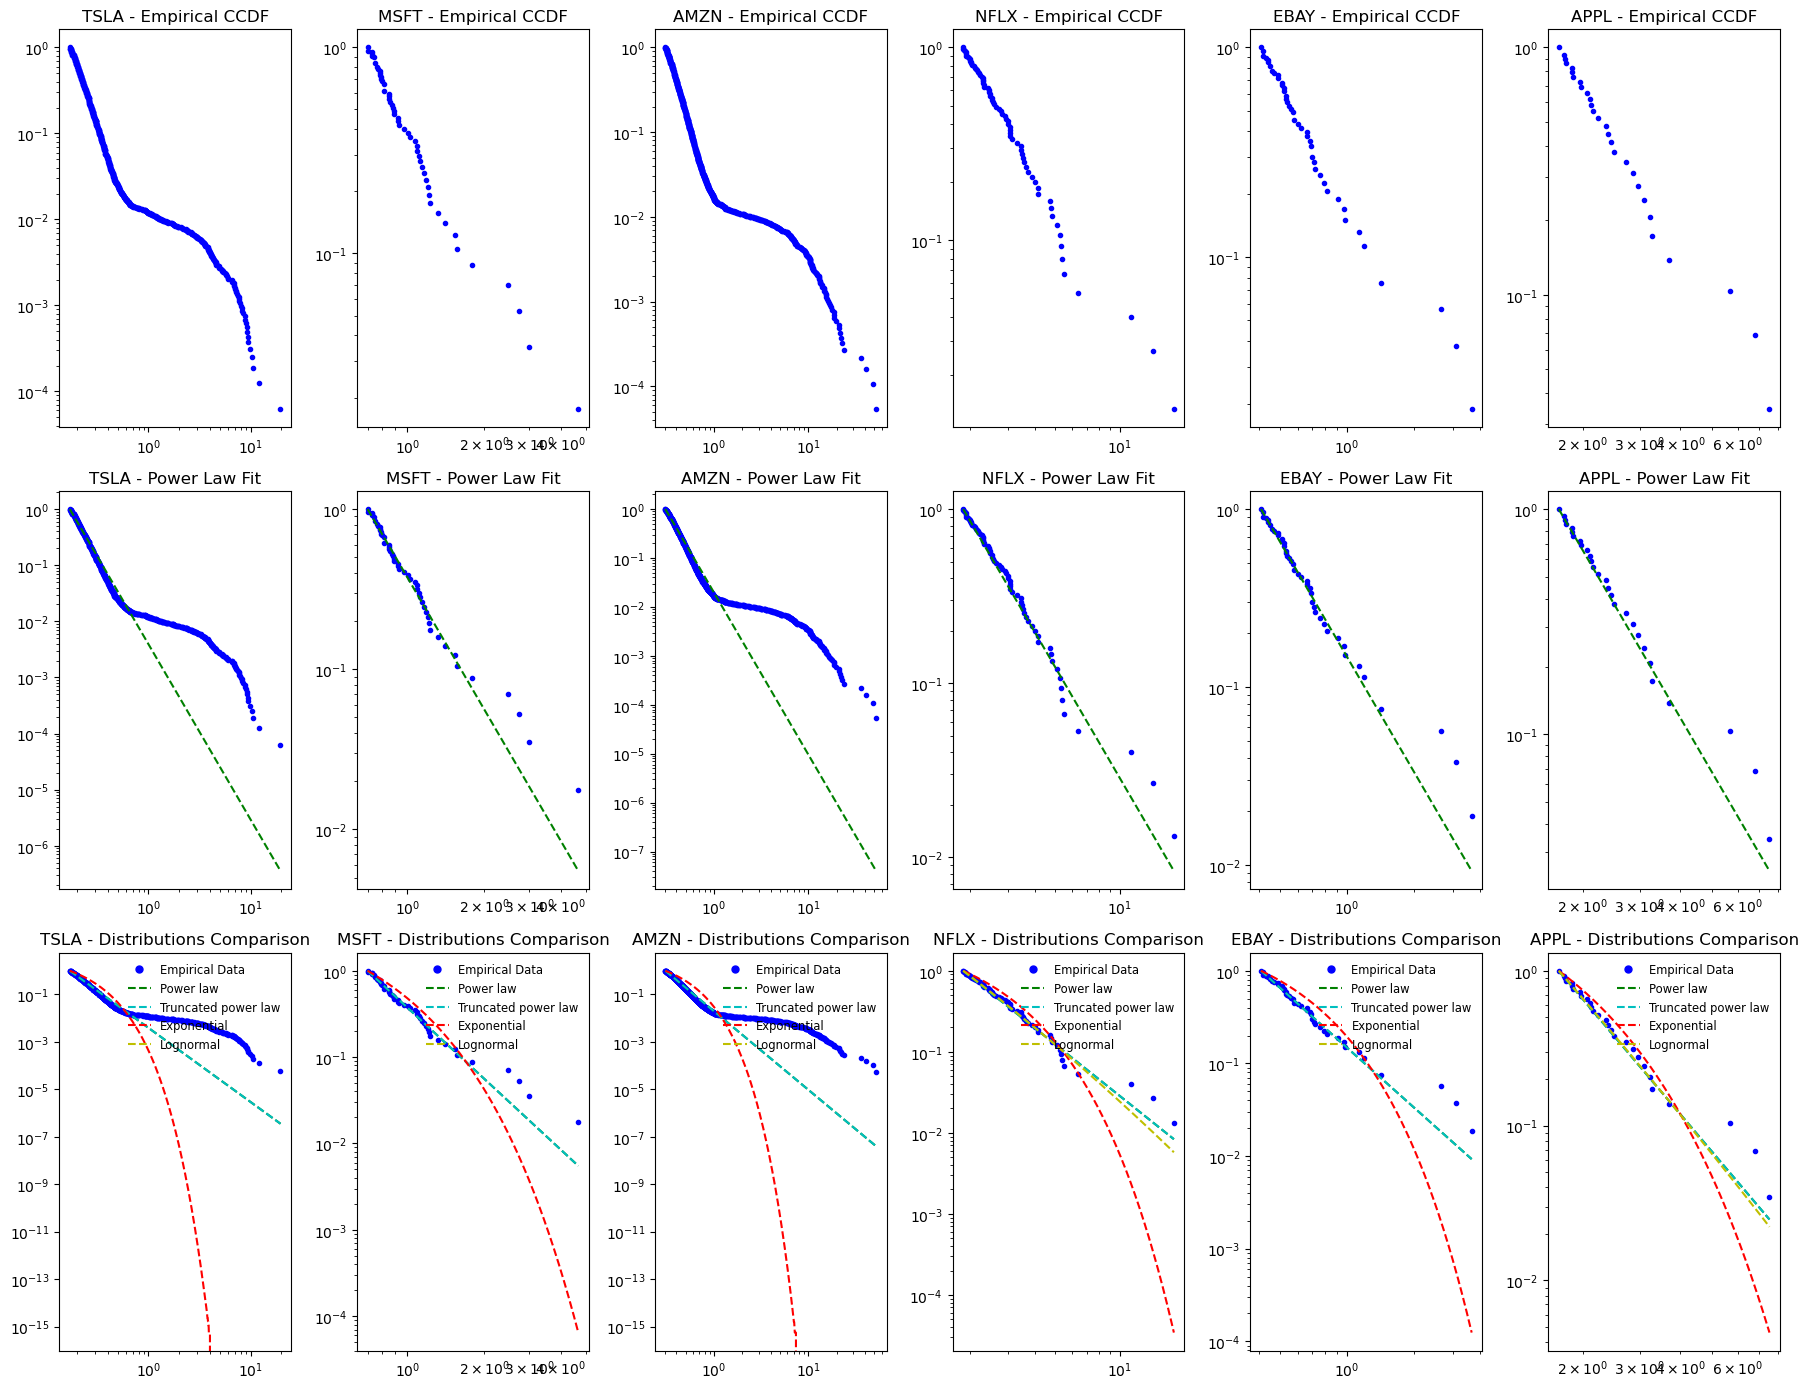

In [33]:
# Plot fitted objects
plot_fit_objects(volatility_fit_objects)

#### 4.3.1. Retrieve Power law fitting results

In [34]:
# Get fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'power_law')
print(volatility_fit_results)

  Stock Distribution     alpha   xmin  KS Distance
0  TSLA    power_law  4.129168  0.170     0.046950
1  MSFT    power_law  3.741539  0.700     0.056192
2  AMZN    power_law  4.308060  0.305     0.032532
3  NFLX    power_law  3.113174  1.855     0.055235
4  EBAY    power_law  3.139655  0.410     0.052937
5  APPL    power_law  3.477862  1.690     0.053846


In [35]:
# Average Alpha exponents across stocks
min_alpha = volatility_fit_results['alpha'].min()
max_alpha = volatility_fit_results['alpha'].max()
avg_alpha = volatility_fit_results['alpha'].mean()
std_dev_alpha = volatility_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.1131743625399455
Max Alpha: 4.308060473944172
Average Alpha: 3.6515764924198812
std_dev_alpha: 0.4998549256101555


#### 3.3.2. Compare Alternative Distributions

In [36]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volatility_powerlaw_exponential = distribution_compare(volatility_fit_objects, 'exponential')
display(volatility_powerlaw_exponential)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,9.328778,0.170,4.129168,0.046950,0.204058,13.293234,2.533864e-40
1,MSFT,exponential,2.430223,0.700,3.741539,0.056192,0.156500,1.759675,7.846290e-02
2,AMZN,exponential,5.044200,0.305,4.308060,0.032532,0.235782,13.608954,3.542762e-42
3,NFLX,exponential,0.642562,1.855,3.113174,0.055235,0.120930,1.398784,1.618777e-01
4,EBAY,exponential,2.771269,0.410,3.139655,0.052937,0.171475,2.106569,3.515495e-02
5,APPL,exponential,0.923536,1.690,3.477862,0.053846,0.096162,1.075553,2.821274e-01
